# **24. HuggingFace 커스텀 프로젝트 만들기 [프로젝트]**
<br>

# **24-1. 프로젝트 : 커스텀 프로젝트 직접 만들기**
<br>

### **라이브러리 버전 확인**
<br>

In [103]:
!pip uninstall transformers -y
!pip install transformers

Found existing installation: transformers 4.33.1
Uninstalling transformers-4.33.1:
  Successfully uninstalled transformers-4.33.1
  Using cached transformers-4.33.1-py3-none-any.whl (7.6 MB)


In [104]:
!pip install datasets

In [105]:
import tensorflow as tf
import numpy as np
import transformers
import datasets

In [106]:
print(tf.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.13.0
1.23.5
4.33.1
2.14.5


<br><br>

### **STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성**
<br>

In [107]:
# NSMC 데이터셋 불러오기

In [108]:
from datasets import load_dataset

In [537]:
nsmc_dataset = load_dataset("nsmc")

<br>

In [110]:
# NSMC 데이터 확인 및 분석

In [538]:
nsmc_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [539]:
# Train 데이터셋에서 각 특성의 값을 2개 샘플 출력
for i in range(2):
    print(f"Sample {i+1}:")
    print("ID:", nsmc_dataset['train']['id'][i])
    print("Document:", nsmc_dataset['train']['document'][i])
    print("Label:", nsmc_dataset['train']['label'][i])
    print("-" * 50)

Sample 1:
ID: 9976970
Document: 아 더빙.. 진짜 짜증나네요 목소리
Label: 0
--------------------------------------------------
Sample 2:
ID: 3819312
Document: 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
Label: 1
--------------------------------------------------


<br>

In [113]:
# train set에서 text와 label만 추출하여 가공하기

In [540]:
# 데이터 처리 함수
def process_data(batch):
    return {"text": batch["document"], "label": batch["label"]}

In [541]:
# Train dataset 가공
processed_train_dataset = nsmc_dataset["train"].map(process_data, remove_columns=["id", "document"])

In [542]:
# Test dataset 가공
processed_test_dataset = nsmc_dataset["test"].map(process_data, remove_columns=["id", "document"])

<br>

In [543]:
# 결과 확인
print("Train Set Sample:")
print(processed_train_dataset[0])
print("-" * 50)

print("Test Set Sample:")
print(processed_test_dataset[0])

Train Set Sample:
{'label': 0, 'text': '아 더빙.. 진짜 짜증나네요 목소리'}
--------------------------------------------------
Test Set Sample:
{'label': 1, 'text': '굳 ㅋ'}


<br><br>

### **STEP 2. klue/bert-base model 및 tokenizer 불러오기**
<br>

In [544]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [545]:
# klue/bert-base 토크나이저
klue_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [546]:
# klue/bert-base 모델
klue_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<br><br>

### **STEP 3. 위에서 불러온 tokenizer로 데이터셋을 전처리하고, model 학습 진행해 보기**
<br>

##### **klue_tokenizer로 데이터셋 전처리하기**
<br>

In [547]:
# max_length 적정성 확인 (문장 길이 분포 확인할 수 있는 히스토그램 출력)

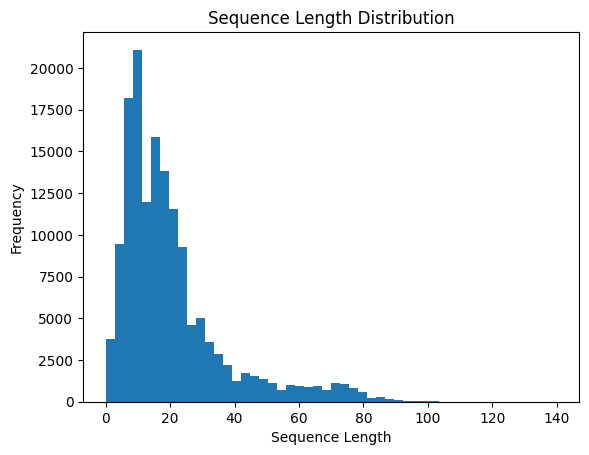

90th percentile: 42
95th percentile: 60
99th percentile: 79


In [548]:
import matplotlib.pyplot as plt

# truncation 없이 토큰화하기
lengths = processed_train_dataset.map(lambda x: {'length': len(klue_tokenizer.tokenize(x['text']))})

# length feature를 list에 추가하기
lengths_list = [item['length'] for item in lengths]

# 그래프 그리기
plt.hist(lengths_list, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

# 백분위수 확인
for percentile in [90, 95, 99]:
    value = int(np.percentile(lengths_list, percentile))
    print(f"{percentile}th percentile: {value}")

<br>

In [549]:
# transform 함수 만들기

In [550]:
def klue_transform(batch):
    return klue_tokenizer(
        batch['text'],
        truncation=True,
        padding='max_length',
        max_length=100,
        return_token_type_ids=False
    )

In [551]:
# 데이터셋에 transformation 적용하기

In [552]:
transformed_train_dataset = processed_train_dataset.map(klue_transform, batched=True)
transformed_test_dataset = processed_test_dataset.map(klue_transform, batched=True)

<br>

In [553]:
# original dataset 확인
print("Before Transformation:")
print("Features:", processed_train_dataset.features)
print("-" * 50)
print("Sample Entry:")
print(processed_train_dataset[0])
print("\n\n")

Before Transformation:
Features: {'label': ClassLabel(names=['negative', 'positive'], id=None), 'text': Value(dtype='string', id=None)}
--------------------------------------------------
Sample Entry:
{'label': 0, 'text': '아 더빙.. 진짜 짜증나네요 목소리'}





In [554]:
# transformed dataset 확인
print("After Transformation:")
print("Features:", transformed_train_dataset.features)
print("-" * 50)
print("Sample Entry:")

sample_entry = transformed_train_dataset[0]
for key, value in sample_entry.items():
    print(f"{key}:\n{value}\n")
print("\n\n")

After Transformation:
Features: {'label': ClassLabel(names=['negative', 'positive'], id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
--------------------------------------------------
Sample Entry:
label:
0

text:
아 더빙.. 진짜 짜증나네요 목소리

input_ids:
[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

attention_mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<br><br>

##### **TrainingArguments로 학습 관련 설정하기**
<br>

In [129]:
from transformers import Trainer, TrainingArguments

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
!ls /content/drive/MyDrive/Colab/05_Colab_AIFFEL_2023/09_GOINGDEEPER/01_GD_NLP/Quest_08/transformers

checkpoint-500	runs


In [132]:
output_dir = '/content/drive/MyDrive/Colab/05_Colab_AIFFEL_2023/09_GOINGDEEPER/01_GD_NLP/Quest_08/transformers'

In [133]:
# !pip install accelerate -U
# !pip install transformers[torch]

In [134]:
'''
training_arguments = TrainingArguments(
    output_dir,                         # output이 저장될 경로
    evaluation_strategy="epoch",        # evaluation하는 빈도
    learning_rate = 2e-5,               # learning_rate
    per_device_train_batch_size = 16,   # 각 device 당 batch size
    per_device_eval_batch_size = 16,    # evaluation 시에 batch size
    num_train_epochs = 3,               # train 시킬 총 epochs
    weight_decay = 0.01,                # weight decay
)
'''

'\ntraining_arguments = TrainingArguments(\n    output_dir,                         # output이 저장될 경로\n    evaluation_strategy="epoch",        # evaluation하는 빈도\n    learning_rate = 2e-5,               # learning_rate\n    per_device_train_batch_size = 16,   # 각 device 당 batch size\n    per_device_eval_batch_size = 16,    # evaluation 시에 batch size\n    num_train_epochs = 3,               # train 시킬 총 epochs\n    weight_decay = 0.01,                # weight decay\n)\n'

<br>

In [135]:
total_dataset_size = len(transformed_train_dataset)
total_dataset_size

150000

In [136]:
required_batch_size = total_dataset_size // 1000
required_batch_size

150

In [138]:
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=required_batch_size,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",  # 로깅 스텝마다 평가 및 저장
    save_steps=10,
    save_total_limit=2,           # 마지막 2 모델만 저장 (보다 오래된 게 삭제됨.)
    load_best_model_at_end=True   # 평가된 것 중 제일 성능 좋은 모델을 로드함.
)

In [139]:
print(f"Updated per_device_train_batch_size: {required_batch_size}")

Updated per_device_train_batch_size: 150


<br>

##### **Metric 설정 (NSMC는 sentiment analysis를 위한 binary classification 문제)**
<br>

In [140]:
from datasets import load_metric
metric = load_metric('accuracy')

In [141]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<br>

##### **model 학습 진행 (Trainer 활용)**
<br>

In [555]:
# 데이터셋 분할(train/validation)

In [556]:
from datasets import concatenate_datasets

def split_dataset(dataset, train_ratio=0.9):
    n = len(dataset)
    train_size = int(train_ratio * n)

    train_datasets = [dataset.shard(num_shards=10, index=i) for i in range(int(10*train_ratio))]
    val_datasets = [dataset.shard(num_shards=10, index=i) for i in range(int(10*train_ratio), 10)]

    train_dataset = concatenate_datasets(train_datasets)
    val_dataset = concatenate_datasets(val_datasets)

    return train_dataset, val_dataset

In [557]:
train_dataset, val_dataset = split_dataset(transformed_train_dataset, train_ratio=0.9)

In [558]:
train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 135000
})

In [559]:
val_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 15000
})

<br>

In [142]:
# Trainer 생성하기

In [560]:
from transformers import EarlyStoppingCallback

In [562]:
trainer = Trainer(
    model=klue_model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_threshold=0.001, early_stopping_patience=3)]
)

<br>

In [563]:
# 모델 학습

In [564]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,0.719800,0.709124,0.490867
20,0.707900,0.687797,0.544333
30,0.680700,0.652534,0.646400
40,0.640300,0.604438,0.728667
50,0.595500,0.546533,0.771667
60,0.526900,0.472083,0.814267
70,0.467500,0.411473,0.828400
80,0.419600,0.384304,0.839267
90,0.396400,0.365839,0.844133
100,0.372000,0.358448,0.846733


TrainOutput(global_step=180, training_loss=0.46418420208825006, metrics={'train_runtime': 634.3566, 'train_samples_per_second': 212.814, 'train_steps_per_second': 1.419, 'total_flos': 1387499706000000.0, 'train_loss': 0.46418420208825006, 'epoch': 0.2})

<br><br>

### **STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기**
<br>

+ 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

<br>

In [589]:
train_dataset, val_dataset = split_dataset(transformed_train_dataset, train_ratio=0.9)

In [590]:
train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 135000
})

In [591]:
val_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 15000
})

In [592]:
# 학습률 스케줄러와 배치 크기 설정

In [593]:
from transformers import get_scheduler
from transformers import AdamW

In [594]:
# AdamW 옵티마이저 생성
optimizer = AdamW(klue_model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [595]:
training_arguments = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=required_batch_size,  # 이 부분을 조절하여 배치 크기를 변경
    per_device_eval_batch_size=64,  # 이 부분을 조절하여 배치 크기를 변경
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
)

In [596]:
# 학습률 스케줄러 설정

In [597]:
num_training_steps = len(train_dataset) // required_batch_size * training_arguments.num_train_epochs

In [598]:
trainer = Trainer(
    model=klue_model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_threshold=0.001, early_stopping_patience=3)],
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,0.295100,0.298077,0.874133


<br><br>

### **STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교**
<br>

+ 아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.

+ STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [504]:
# 1. 데이터셋 준비

In [505]:
transformed_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 150000
})

In [506]:
transformed_test_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 50000
})

<br>

In [515]:
# 2. 데이터셋 분할

In [520]:
train_dataset, val_dataset = split_dataset(transformed_train_dataset, train_ratio=0.9)

In [521]:
train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 135000
})

In [522]:
val_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 15000
})

<br>

In [523]:
# 2. 토크나이저와 데이터 collator 준비

In [524]:
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

In [525]:
tokenizer =klue_tokenizer

In [526]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

<br>

In [566]:
# 3. TrainingArguments 설정

In [527]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=required_batch_size,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_tensorboard',  # TensorBoard 로그가 저장될 디렉터리
    logging_steps=10,                  # 얼마나 자주 로그를 저장할 것인지 설정 (예: 10스텝마다)
    evaluation_strategy="steps",
    save_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    group_by_length=True
)

<br>

In [565]:
# 4. Metric 설정은 위와 동일하므로 생략

<br>

In [567]:
# 5. Trainer 설정

In [530]:
trainer = Trainer(
    model=klue_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_threshold=0.001, early_stopping_patience=3)]
)

<br>

In [531]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
10,0.307800,0.274158,0.887133
20,0.307100,0.277128,0.886067
30,0.270200,0.272834,0.888400
40,0.318700,0.271807,0.889933
50,0.287900,0.270182,0.888400
60,0.282300,0.272542,0.889267
70,0.276800,0.273952,0.888533
80,0.304100,0.268922,0.889133
90,0.294900,0.269007,0.890600
100,0.293400,0.269252,0.886667


TrainOutput(global_step=110, training_loss=0.2971065889705311, metrics={'train_runtime': 386.2394, 'train_samples_per_second': 349.524, 'train_steps_per_second': 2.33, 'total_flos': 847916487000000.0, 'train_loss': 0.2971065889705311, 'epoch': 0.12})

<br>

In [534]:
!kill $(ps aux | grep '[t]ensorboard' | awk '{print $2}')

In [535]:
%load_ext tensorboard
%tensorboard --logdir ./logs_tensorboard --port 6007

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

<br>

##### **STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교**
<br>

transformers로 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보면

훈련 시간은 확실히 줄었으며, 성능의 차이가 크게 나진 않았지만, 훈련 속도의 향상이 있었다고 분석할 수 있습니다.

<br><br>

# **24-2. 프로젝트 제출**
<br>

### **루브릭**
<br>

|<big>평가문항</big>|<big>상세기준</big>|
|:--|:--|
|<br>**1. 모델과 데이터를 정상적으로 불러오고, 작동하는 것을 확인하였다.**<br><br> | <br>klue/bert-base를 NSMC 데이터셋으로 fine-tuning 하여, 모델이 정상적으로 작동하는 것을 확인하였다.<br><br> |
|<br>**2. Preprocessing을 개선하고, fine-tuning을 통해 모델의 성능을 개선시켰다.**<br><br> | <br>Validation accuracy를 90% 이상으로 개선하였다.<br><br> |
|<br>**3. 모델 학습에 Bucketing을 성공적으로 적용하고, 그 결과를 비교분석하였다.**<br><br> | <br>Bucketing task을 수행하여 fine-tuning 시 연산 속도와 모델 성능 간의 trade-off 관계가 발생하는지 여부를 확인하고, 분석한 결과를 제시하였다.<br><br> |
